# Text Processing

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
import sklearn.feature_extraction.text 
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, mean_squared_error, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
df = pd.read_csv('final_df.csv')

In [3]:
# Drop unnamed column
df.drop(columns='Unnamed: 0', inplace=True)

In [4]:
print(df.shape)
df.info()

(19886, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19886 entries, 0 to 19885
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    19886 non-null  int64 
 1   clean_title  19856 non-null  object
dtypes: int64(1), object(1)
memory usage: 310.8+ KB


As there is some null rows, I proceed to clean it.

In [5]:
empty = pd.isnull(df['clean_title'])

In [6]:
# briefly see what are the NaN rows under 'clean_title'
df[empty]

,subreddit,clean_title
143,0,NaN
301,0,NaN
333,0,NaN
548,0,NaN
981,0,NaN
995,0,NaN
1572,0,NaN
2696,0,NaN
2825,0,NaN
3909,0,NaN


In [7]:
df.dropna(subset=['clean_title'], inplace=True)

In [8]:
# Double check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19856 entries, 0 to 19885
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    19856 non-null  int64 
 1   clean_title  19856 non-null  object
dtypes: int64(1), object(1)
memory usage: 465.4+ KB


## Train, Test, Split

Getting my data ready for modelling. First, we split our data into training and testing data.

In [9]:
# X will be the feature
# y will be the response variable
X = df['clean_title']
y = df['subreddit']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.30,
                                                   stratify=y,
                                                   random_state=42)

## CountVectorizer

We will apply Count Vectorizer without analyzing the best parameters first.

In [11]:
cvec = CountVectorizer(stop_words='english', max_features=100) # Instantiate
X_train = cvec.fit_transform(X_train) # Fit and transform

X_train_df = pd.DataFrame(X_train.toarray(),columns=cvec.get_feature_names())

In [12]:
X_train_df.sum().sort_values(ascending=False).head(20)

dog       4326
cat       2521
pron      1200
help       837
new        622
year       587
old        574
like       552
puppy      472
love       456
good       446
need       430
look       399
breed      383
advice     356
know       345
time       322
day        321
eat        320
kitten     320
dtype: int64

In [13]:
#Understand which words belong udner which subreddit
n_words = 40
words = list(X_train_df.sum().sort_values(ascending=False)[:n_words].index) # take the top 40 words that appear into a list
X_train_df['subreddit'] = y_train.values # creating a column and assigning the subreddit 0 and 1 to the index

In [14]:
# Showing which subreddit the top 40 words belong to
X_train_df_small = X_train_df.groupby('subreddit').sum()[words]
X_train_df_small.head().T

subreddit,0,1
dog,60,4266
cat,2450,71
pron,860,340
help,223,614
new,414,208
year,427,160
old,240,334
like,376,176
puppy,2,470
love,377,79


There are preliminary thoughts with respect to the words that appear in each subreddit.
<br>
### r/dogs
<li>The word 'help' appears a lot in the r/dogs subreddit.</li>
<li>This could potentially mean that dog lovers/owners who are on Reddit use the forums to seek advice.</li>

### r/cats
<li>Words such as 'new', 'year', 'like' and 'love' appeared more frequently in the cat subreddit. It may signify that people were looking to own cats in the new year. But we will need to delve into each individual post to understand the context.</li>
<br>
Note: Cat enthusiasts/owners may also use the r/cats subreddit to seek advice, but not as frequently as in the r/dogs one. Same for those in r/dogs - they may look forward to owning a dog in the new year, but are not posting frequent enough on the reddit platform with respect to that topic.

## Baseline Accuracy

In [15]:
y_test.value_counts(normalize=True)

1    0.500252
0    0.499748
Name: subreddit, dtype: float64

The splits are rather even as we have stratified our training and test based on the binaries in y, on top of that we scraped rather equal documents from the r/cats and r/dogs subreddits. We would also have a baseline accuracy of 50.0%, i.e. if we predicted that all posts came from r/dogs, we would be 50.5% accurate.

## `Random Forest Classifier` and `CountVectorizer`

Random Forest will be the first model that we will implement.

In [16]:
# Set up pipeline
pipe_rf_c = Pipeline([
    ('cvec', CountVectorizer(stop_words='english', max_features=500, ngram_range=(1,2))),
    ('rf', RandomForestClassifier())
])

# Set up pipeline parameters
pipe_rf_c_params = {
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 5, 6], 
    'rf__max_features': ['auto', 'log2'],
    'rf__min_samples_split': [2, 50]}

Without wasting too much time, we can utilise GridSearchCV to find the best parameters for our models. This will be repeated in the other models.

In [17]:
# Instantiate GridSearch to find the best parameters
gs_rf_c = GridSearchCV(pipe_rf_c, pipe_rf_c_params, cv=5)

# Fit model
gs_rf_c.fit(X_test, y_test);

In [18]:
# Find best score (GridSearch)
gs_rf_c.best_score_

0.8918891124146986

In [19]:
# Find best parameters
gs_rf_c.best_params_

{'rf__max_depth': None,
 'rf__max_features': 'log2',
 'rf__min_samples_split': 50,
 'rf__n_estimators': 150}

## `Random Forest Classifier` and `TFIDF Vectorizer`

In [20]:
# Set up pipeline
pipe_rf_t = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english', max_features=500, ngram_range=(1,2))),
    ('rf', RandomForestClassifier())
])

# Set up pipeline parameters
pipe_rf_t_params = {
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 5, 6], 
    'rf__max_features': ['auto', 'log2'],
    'rf__min_samples_split': [2, 50, 100]
}

In [21]:
# Instantiate GridSearch
gs_rf_t = GridSearchCV(pipe_rf_t, pipe_rf_t_params, cv=5, verbose=1)

In [22]:
# Fit gridsearch
gs_rf_t.fit(X_test, y_test);

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [23]:
# Find best score
gs_rf_t.best_score_

0.8933997430392372

In [24]:
# Find best parameters
gs_rf_t.best_params_

{'rf__max_depth': None,
 'rf__max_features': 'log2',
 'rf__min_samples_split': 2,
 'rf__n_estimators': 150}

## `Naive Bayes` and `CountVectorizer`

In [25]:
# Set up pipeline
pipe_nb_c = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())])

In [26]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [27]:
# Instantiate GridSearchCV.

gs_nb_c = GridSearchCV(pipe_nb_c, 
                  param_grid=pipe_params, 
                  cv=5) # 5-fold cross-validation.

In [28]:
# Fit GridSearch
gs_nb_c.fit(X_test, y_test)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words='english')),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [29]:
# Best Score
print(gs_nb_c.best_score_)

0.8930640316918275


In [30]:
# Find best parameters
gs_nb_c.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

## `Naive Bayes` and `TFIDF Vectorizer`

In [31]:
# Set up pipeline
pipe_nb_t = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# Set up pipeline parameters
params_grid = {
    'nb__alpha': [1.0], 
   'nb__fit_prior': [True, False]
}

In [32]:
# Set up GridSearchCV
gs_nb_t = GridSearchCV(pipe_nb_t,param_grid=params_grid
                       , cv=5,verbose=1)

In [33]:
# Fit GridSearchCV model
gs_nb_t.fit(X_test, y_test);

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [34]:
# Best Score
print(gs_nb_t.best_score_)

0.8833274164736643


In [35]:
# Find best parameters
gs_nb_t.best_params_

{'nb__alpha': 1.0, 'nb__fit_prior': False}

## `Logistic Regression` and `CountVectorizer`

In [36]:
# Set up pipeline
pipe_lr_c = Pipeline([
    ('cvec', CountVectorizer(stop_words='english', ngram_range=(1,2))),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=5000))
])

# Set up pipeline parameters
pipe_lr_c_params = {
    'cvec__max_features': [200, 500],
}

In [37]:
# Set up GridSearchCV
gs_lr_c = GridSearchCV(pipe_lr_c, pipe_lr_c_params, cv=5, verbose=1)

# Fit GridSearchCV model
gs_lr_c.fit(X_test, y_test);

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [38]:
# Find Best Score
gs_lr_c.best_score_

0.8892029990025865

In [39]:
# Find Best Parameters
gs_lr_c.best_params_

{'cvec__max_features': 500}

## `Logistic Regression` and `TFIDF Vectorizer`

In [40]:
# Set up pipeline

pipe_lr_t = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=5000))
])

# Set up pipeline parameters
pipe_lr_t_params = {
    'tvec__max_features': [200, 500]
}

In [41]:
# Instantiate GridSearchCV
gs_lr_t = GridSearchCV(pipe_lr_t, pipe_lr_t_params, cv=5, verbose =1)

# Fit GridSearchCV
gs_lr_t.fit(X_test, y_test)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('lr',
                                        LogisticRegression(max_iter=5000))]),
             param_grid={'tvec__max_features': [200, 500]}, verbose=1)

In [42]:
# Best Score
gs_lr_t.best_score_

0.8925605351095184

In [43]:
# Best parameters
gs_lr_t.best_params_

{'tvec__max_features': 500}

## Compare Models

In [44]:
# Generate a dataframe of model & accuracy score
list_of_models = [gs_rf_c, gs_rf_t, 
                  gs_nb_c, gs_nb_t,
                  gs_lr_c, gs_lr_t]

# Create an empty list for each model's dictionary
models = []

for mod in list_of_models:
    # mod.best_score_
    model = {}
    model['type'] = str(list(mod.estimator.named_steps.keys()))
    model['accuracy'] = mod.best_score_
    models.append(model)

# Append baseline for comparison
baseline = {}
baseline['type'] = 'baseline'
baseline['accuracy'] = y_train.value_counts(normalize=True)[1]
models.append(baseline)

# change it into a DataFrame
models_df = pd.DataFrame(models)
models_df.head(6)

,type,accuracy
0,"['cvec', 'rf']",0.891889
1,"['tvec', 'rf']",0.893400
2,"['cvec', 'nb']",0.893064
3,"['tvec', 'nb']",0.883327
4,"['cvec', 'lr']",0.889203
5,"['tvec', 'lr']",0.892561


# Analysis

### Confusion Matrix

### Accuracy

It is important to find out the accuracy of the models in comparison to the baseline.

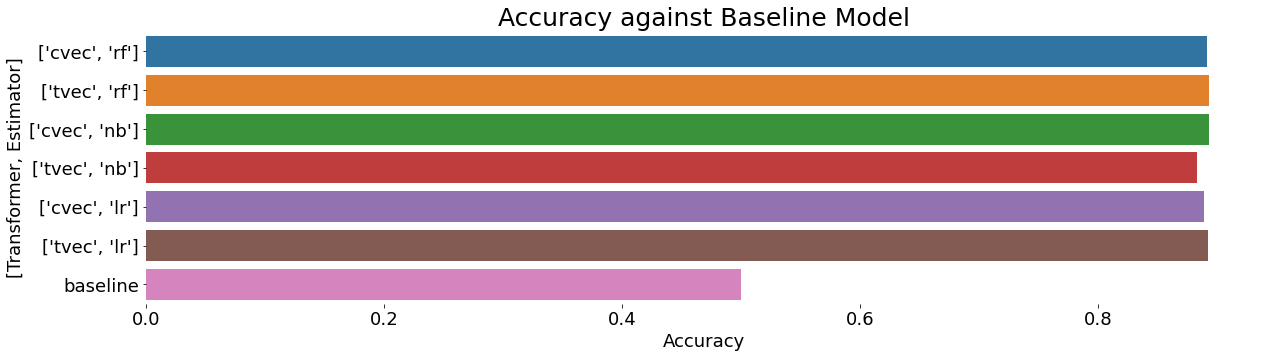

In [45]:
plt.figure(figsize=(20,5))
sns.barplot(data=models_df, x='accuracy', y='type')
plt.xlabel('Accuracy', size=18)
plt.ylabel('[Transformer, Estimator]', size=18)
plt.yticks(size=18)
plt.xticks(size=18)
plt.title('Accuracy against Baseline Model', size=25)
sns.despine(left=True, bottom=True);

Most of the models perform well when predicting which posts fall under which subreddit. We have utilised GridSearchCV to find out the best parameters to use for each model.

We will further analyse the 2 best performing models - Random Forest + TFIDF Vectorizer (89.41%) and Naive Bayes + CountVectorizer (89.31%).

## Comparing `Random Forest` + `TFIDF` and `Naive Bayes` + `Count Vectorizer`

With the best parameters that we computed above from GridSearchCV, we will now set up the Pipeline.

In [46]:
# Define X and y
X = df['clean_title']
y = df['subreddit']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.30, 
                                                    random_state=42)

### `Random Forest` + `Tfidf Vectorizer`

In [47]:
# Set up pipeline
pipe_rf_t = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english', max_features=500, ngram_range=(1,2))),
    ('rf', RandomForestClassifier())
])

# Set up pipeline parameters
pipe_rf_t_params = {
    'rf__n_estimators': [150],
    'rf__max_depth': [None], 
    'rf__max_features': ['log2'],
    'rf__min_samples_split': [2]
}

In [48]:
# Instantiate GridSearch
gs_rf_t = GridSearchCV(pipe_rf_t, pipe_rf_t_params, cv=5, verbose=1)

In [49]:
# Fit gridsearch
gs_rf_t.fit(X_test, y_test);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [50]:
# Score model on train data
gs_rf_t.score(X_train, y_train)

0.8889128714295993

In [51]:
# Score model on train data
gs_rf_t.score(X_test, y_test)

0.9565217391304348

In [52]:
preds = gs_rf_t.predict(X_test)
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [53]:
# Create DataFrame for Confusion Matrix (RF+TFIDF)
cm_df = pd.DataFrame(cm, 
             columns=['Predicted Cats', 'Predicted Dogs'], 
             index=['Actual Cats', 'Actual Dogs'])
cm_df

,Predicted Cats,Predicted Dogs
Actual Cats,2924,61
Actual Dogs,198,2774


In [54]:
print("\nAccuracy: ", (tn + tp) / (tn + fp + fn + tp))
print("Sensitivity: ", tp / (tp + fn))
print("Specificity: ", tn / (tn + fp))
print("Precision: ", tp / (tp + fp))
print("Misclassification rate: ",  (fp + fn) / (tn + fp + fn + tp))


Accuracy:  0.9565217391304348
Sensitivity:  0.933378196500673
Specificity:  0.9795644891122278
Precision:  0.9784832451499118
Misclassification rate:  0.043478260869565216


### `Naive Bayes` + `Count Vectorizer`

In [55]:
# Set up pipeline
pipe_nb_c = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())])

In [56]:
pipe_params = {
    'cvec__max_features': [4_000],
    'cvec__min_df': [2],
    'cvec__max_df': [.9],
    'cvec__ngram_range': [(1,2)]
}

In [57]:
# Instantiate GridSearchCV.

gs_nb_c = GridSearchCV(pipe_nb_c, 
                  param_grid=pipe_params, 
                  cv=5) # 5-fold cross-validation.

In [58]:
# Fit GridSearch
gs_nb_c.fit(X_test, y_test)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words='english')),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [4000],
                         'cvec__min_df': [2], 'cvec__ngram_range': [(1, 2)]})

In [59]:
preds = gs_nb_c.predict(X_test)
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [60]:
# Create DataFrame for Confusion Matrix
cm_df = pd.DataFrame(cm, 
             columns=['Predicted Cats', 'Predicted Dogs'], 
             index=['Actual Cats', 'Actual Dogs'])
cm_df

,Predicted Cats,Predicted Dogs
Actual Cats,2858,127
Actual Dogs,185,2787


In [61]:
print("\nAccuracy: ", (tn + tp) / (tn + fp + fn + tp))
print("Sensitivity: ", tp / (tp + fn))
print("Specificity: ", tn / (tn + fp))
print("Precision: ", tp / (tp + fp))
print("Misclassification rate: ",  (fp + fn) / (tn + fp + fn + tp))


Accuracy:  0.9476246432768172
Sensitivity:  0.9377523553162853
Specificity:  0.9574539363484087
Precision:  0.956417295813315
Misclassification rate:  0.05237535672318281


In [62]:
# Score model on train data
gs_nb_c.score(X_train, y_train)

0.9109288438017124

In [63]:
# Score model on test data
gs_nb_c.score(X_test, y_test)

0.9476246432768172

|Model|Training Score|Test Score/Accuracy|Vectorizer|
|---|---|---|---|
|Random Forest|0.8895|0.9565|TFIDF|
|Naive Bayes|0.9109|0.9476|CountVectorizer|

Both models perform rather well in fitting with the training data, but the Naive Bayes model scoring better by 2%. There is more underfitting in the Random Forest model, however the test data is able to fit the model much better than on the Naive Bayes model.

With such close scores, we can look towards the Confusion Matrix. In this problem, I base it on the Accuracy of the models. This means that we wanted to predict that future posts in r/cats and r/dogs would be correctly predicted into their subreddits.

This is important for the model to do so - which allows us to ensure that our business model (eventually selected by CatDog) remains relevant and popular. If, in the event that the accuracy is no longer high, there needs to be a tweaking of the parameters in order to suit the changes within the subreddits.


Therefore, we will use Random Forest + Tfidf Vectorizer.

### Improvements to the Model
<br>
<li> For modeling rigor, literal subreddit name references should have been removed as individual words (e.g. "dog", "cat") were left in earlier on.
<li>Having posts with more unique words helps to distinguish between spam and ham but;
<li>Not all posts with unique words are relevant, so we have to focus more on the coefficient of frequently appearing words
<li> Perhaps this project could be improved by performing a form of sentiment analysis on the data in future studies. Lastly, though this model scored only around ~ 90% accuracy on testing data, this model still predicts much better than the baseline (~ 50.6%) and might be helpful in differentiating between dogs and cats.
<li> Further analysis can be done on the emojis within the titles.

### Business Recommendations
<br>
<li>Explore other forums that are more local e.g. Hardwarezone because Reddit posts are more global and may not attune well to local context even though CatDog wants to reach out to an international clientele. Starting small within the local context would be a better way to 'taste' the market first.
<li>r/dogs - more practical and ‘discussion’ driven
Create consultancy and onboarding services for new dog owners
<li>If interested to bring in breeds, the top words can signify the popular ones among dog lovers
<li>r/cats - sharing of digital media
Grooming services or venture into F&B (e.g. cat café)
<li>Usage of Words for Impactful Marketing - based on the violin plots, words in marketing tools should target to have unique words for r/dogs < 8 and r/cats < 5. As a base guideline, marketing the business model should fit the behaviour of the posters within the subreddit.

### Conclusion
Why Random Forest? It provides higher accuracy through cross validation. Random forest classifier will handle the missing values and maintain the accuracy of a large proportion of data. This will be useful to upscale the model, especially to scrape more than 10,000 per subreddit. If there are more trees, it won’t allow over-fitting trees in the model. It has the power to handle a large data set with higher dimensionality.